In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 28 11:38:35 2023

The MPC controller takes in the previous RTN state computed (not the measured 'x' variable)
"""

import math
import matplotlib.pyplot as plt
import numpy as np

from math import sqrt, sin, asin, cos, tan, atan2, pi
from numpy.linalg import norm, inv, pinv
from scipy.linalg import expm, sinm, cosm

from source import spacecraft
from aa273_control import *


In [2]:

##############################################################################
##############################################################################
###                                                                        ###
###               SETTING UP OF THE GPS CONSTELLATION BELOW                ###
###                                                                        ###
##############################################################################
##############################################################################

#region
# GPS Almanac Week 204: All available PRN IDs
prns = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         7, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31 ]

# GPS Almanac Week 204: Semi-Major Axis [km]
GPS_SMAX = 26599.800

# GPS Almanac Week 204: Eccentricity [unitless]
GPS_ECCN = 0.000001

# GPS Almanac Week 204: Inclination [deg]
GPS_INCL = 55.0
        
# GPS Almanac Week 204: Right Angle of the Ascending Node [deg]
GPS_RAAN = [-143.881352, -149.446614,  -84.778512,  -22.818990,  -87.385619,
            -144.357305,   35.349176,  153.734801,  -26.028092,  -84.931462,
            -141.883192,   99.225855,  -16.924009,   97.083800,  -32.683446,
             100.277002,  158.759866, -143.755546,  161.314101,  -94.320245,
            -149.686511,  -86.467123,   30.236113,   94.562051,   91.458499,
             155.031466,   33.155708,  159.555151,   35.770562,   36.473751,
             -25.294003]

# GPS Almanac Week 204: Argument of Periapsis [deg]
GPS_ARGP = [  53.765545,  -75.631986,   57.743969, -173.043165,   64.681857,
             -46.573319, -127.231250,   13.148360,  112.699728, -139.444742,
            -154.121597,   76.981738,   53.130934, -176.496584,   67.669709,
              44.494200,  -81.162593, -178.499508,  128.866153, -166.197417,
             -45.969586, -177.202756,   50.789967,   59.425199,   26.153212,
              40.480607,   96.978207,  136.728158, -151.319311,   29.645619,
            -128.456075]

# GPS Almanac Week 204: Mean Anomaly [deg]
GPS_ANOM = [ -86.960177, -144.505126, -152.714424,   13.494215,   61.374757,
             -74.233353, -120.546970,   39.999955,   59.759746,  152.572997,
              -2.914681, -167.377052,   14.453008, -163.841686,  -15.388842,
              87.047746,   37.617981,  -80.040336,  160.861859,  -37.675960,
              36.690388, -139.207914,  -70.966229, -173.403954,  142.599792,
              40.680892,  147.604237,   43.801439, -129.846039, -157.112496,
              78.628936]

# Initialize both chief and deputy.
sc1_elements = [6918.14, 0.00001, 97.59760, 0.000000, -109.33800,   0.00827]
sc2_elements = [6918.14, 0.00722, 97.5976, 134.94389, -108.5025, -134.71026] 
sc1 = spacecraft.Spacecraft( elements = sc1_elements )
sc2 = spacecraft.Spacecraft( elements = sc2_elements )

# Set the chief of the spacecraft. Enable maneuvers for SC2.
sc2.chief = sc1 # ROEs and RTN states computed w.r.t. SC1


# Initialize GPS satellite osculating Keplerian elements
gps01oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 0], GPS_ARGP[ 0], GPS_ANOM[ 0]]
gps02oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 1], GPS_ARGP[ 1], GPS_ANOM[ 1]]
gps03oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 2], GPS_ARGP[ 2], GPS_ANOM[ 2]]
gps04oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 3], GPS_ARGP[ 3], GPS_ANOM[ 3]]
gps05oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 4], GPS_ARGP[ 4], GPS_ANOM[ 4]]
gps06oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 5], GPS_ARGP[ 5], GPS_ANOM[ 5]]
gps07oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 6], GPS_ARGP[ 6], GPS_ANOM[ 6]]
gps08oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 7], GPS_ARGP[ 7], GPS_ANOM[ 7]]
gps09oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 8], GPS_ARGP[ 8], GPS_ANOM[ 8]]
gps10oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[ 9], GPS_ARGP[ 9], GPS_ANOM[ 9]]
gps11oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[10], GPS_ARGP[10], GPS_ANOM[10]]
gps12oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[11], GPS_ARGP[11], GPS_ANOM[11]]
gps13oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[12], GPS_ARGP[12], GPS_ANOM[12]]
gps14oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[13], GPS_ARGP[13], GPS_ANOM[13]]
gps15oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[14], GPS_ARGP[14], GPS_ANOM[14]]
gps16oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[15], GPS_ARGP[15], GPS_ANOM[15]]
gps17oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[16], GPS_ARGP[16], GPS_ANOM[16]]
gps18oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[17], GPS_ARGP[17], GPS_ANOM[17]]
gps19oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[18], GPS_ARGP[18], GPS_ANOM[18]]
gps20oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[19], GPS_ARGP[19], GPS_ANOM[19]]
gps21oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[20], GPS_ARGP[20], GPS_ANOM[20]]
gps22oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[21], GPS_ARGP[21], GPS_ANOM[21]]
gps23oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[22], GPS_ARGP[22], GPS_ANOM[22]]
gps24oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[23], GPS_ARGP[23], GPS_ANOM[23]]
gps25oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[24], GPS_ARGP[24], GPS_ANOM[24]]
gps26oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[25], GPS_ARGP[25], GPS_ANOM[25]]
gps27oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[26], GPS_ARGP[26], GPS_ANOM[26]]
gps28oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[27], GPS_ARGP[27], GPS_ANOM[27]]
gps29oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[28], GPS_ARGP[28], GPS_ANOM[28]]
gps30oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[29], GPS_ARGP[29], GPS_ANOM[29]]
gps31oe = [GPS_SMAX, GPS_ECCN, GPS_INCL, GPS_RAAN[30], GPS_ARGP[30], GPS_ANOM[30]]

# Generate all GPS satellites at initial conditions.
gps01 = spacecraft.Spacecraft( elements = gps01oe )
gps02 = spacecraft.Spacecraft( elements = gps02oe )
gps03 = spacecraft.Spacecraft( elements = gps03oe )
gps04 = spacecraft.Spacecraft( elements = gps04oe )
gps05 = spacecraft.Spacecraft( elements = gps05oe )
gps06 = spacecraft.Spacecraft( elements = gps06oe )
gps07 = spacecraft.Spacecraft( elements = gps07oe )
gps08 = spacecraft.Spacecraft( elements = gps08oe )
gps09 = spacecraft.Spacecraft( elements = gps09oe )
gps10 = spacecraft.Spacecraft( elements = gps10oe )
gps11 = spacecraft.Spacecraft( elements = gps11oe )
gps12 = spacecraft.Spacecraft( elements = gps12oe )
gps13 = spacecraft.Spacecraft( elements = gps13oe )
gps14 = spacecraft.Spacecraft( elements = gps14oe )
gps15 = spacecraft.Spacecraft( elements = gps15oe )
gps16 = spacecraft.Spacecraft( elements = gps16oe )
gps17 = spacecraft.Spacecraft( elements = gps17oe )
gps18 = spacecraft.Spacecraft( elements = gps18oe )
gps19 = spacecraft.Spacecraft( elements = gps19oe )
gps20 = spacecraft.Spacecraft( elements = gps20oe )
gps21 = spacecraft.Spacecraft( elements = gps21oe )
gps22 = spacecraft.Spacecraft( elements = gps22oe )
gps23 = spacecraft.Spacecraft( elements = gps23oe )
gps24 = spacecraft.Spacecraft( elements = gps24oe )
gps25 = spacecraft.Spacecraft( elements = gps25oe )
gps26 = spacecraft.Spacecraft( elements = gps26oe )
gps27 = spacecraft.Spacecraft( elements = gps27oe )
gps28 = spacecraft.Spacecraft( elements = gps28oe )
gps29 = spacecraft.Spacecraft( elements = gps29oe )
gps30 = spacecraft.Spacecraft( elements = gps30oe )
gps31 = spacecraft.Spacecraft( elements = gps31oe )

# endregion

# Group all GPS satellites together into a constellation.
gps_constellation = [ gps01, gps02, gps03, gps04, gps05, gps06, gps07, gps08,
                      gps09, gps10, gps11, gps12, gps13, gps14, gps15, gps16,
                      gps17, gps18, gps19, gps21, gps22, gps23, gps24, gps25,
                      gps25, gps26, gps27, gps28, gps29, gps30, gps31 ]
# end region
##############################################################################
##############################################################################
###                                                                        ###
###              AUXILIARY FUNCTIONS FOR GPS CONSTELLATION                 ###
###                                                                        ###
##############################################################################
##############################################################################
def get_hill_frame(r, v):
    h = np.cross(r, v)  # Angular momentum vector
    r_hat = r / np.linalg.norm(r)  # Local X-axis (R)
    h_hat = h / np.linalg.norm(h)  # Local Z-axis (N)
    y_hat = np.cross(h_hat, r_hat)  # Local Y-axis (T)
    return np.array([r_hat, y_hat, h_hat])

def rv_rtn_to_eci(rv_c_eci, r_rtn, v_rtn):
    r = rv_c_eci[0:3]
    v = rv_c_eci[3:6]
    matrix_eci2rtn = get_hill_frame(r, v)
    nuDot = norm(np.cross(r, v)) / (norm(r)**2)
    omega = np.array([0.0, 0.0, nuDot])
    rho = np.transpose(matrix_eci2rtn) @ r_rtn
    rhoDot = np.transpose(matrix_eci2rtn) @ (v_rtn + np.cross(omega, r_rtn))
    rv_cd_eci = np.zeros(6)
    rv_cd_eci[0:3] = rho
    rv_cd_eci[3:6] = rhoDot
    return rv_cd_eci # This returns the RELATIVE state in ECI

def rv_eci_to_rtn(rv_c_eci, rv_cd_eci):
    r = rv_c_eci[0:3]
    v = rv_c_eci[3:6]
    rho = rv_cd_eci[0:3]
    rhoDot = rv_cd_eci[3:6]
    nuDot = norm(np.cross(r, v)) / (norm(r)**2)  # true anomaly derivative
    omega = np.array([0.0, 0.0, nuDot])
    matrix_eci2rtn = get_hill_frame(r, v)
    r_rtn = matrix_eci2rtn @ rho
    v_rtn = matrix_eci2rtn @ rhoDot - np.cross(omega, r_rtn)
    
    return r_rtn, v_rtn

# Function to convert ECEF (xyz) to Geodetic (lat-lon-alt) coordinates
def ecef_to_geodetic(pos):
    if len(pos) != 3:
        raise ValueError('ECEF to Geodetic: Position vector must be length 3!')
        return np.array([0,0,0])
    earthRad = 6378136.300       # Radius of Earth (WGS84)
    earthEcc = 0.081819190842622 # Earth eccentricity (WGS84)
    x, y, z, r = pos[0], pos[1], pos[2], norm(pos)
    lon = atan2(y,x)
    lat0 = asin(z/r) 
    lat = lat0 # Initial guess
    n, nMax = 0, 3 # Number of iterations
    error, tol = 1, 1E-12
    rxy = norm([x,y])
    while (error > tol) and (n < nMax):
        lat0 = lat
        N = earthRad / sqrt(1 - (earthEcc * sin(lat0))**2)
        lat = atan2(z + (N * earthEcc * earthEcc) * sin(lat0), rxy)
        error = abs(lat - lat0)
        n += 1
    alt = (rxy - cos(lat)) - N
    geodetic = np.array([lat, lon, alt])
    return geodetic

# Computes the azimuth, elevation, and range from positions 0 to 1
def compute_aer(pos0, pos1):
    lla = ecef_to_geodetic(pos0)
    lat, lon = lla[0], lla[1]
    so = sin(lon)
    co = cos(lon)
    sa = sin(lat)
    ca = cos(lat)
    rotation = np.array(
        [[-so,            co, 0.0],
         [-sa * co, -sa * so, ca ],
         [ ca * co,  ca * so, sa ]])
    enu = rotation @ (pos1 - pos0)
    azim = atan2(enu[0], enu[1]);
    elev = atan2(enu[2], norm(enu[0:2]));
    rnge = norm(enu);
    enu = np.array([azim, elev, rnge]);
    return enu

##############################################################################
##############################################################################
###                                                                        ###
###               FUNCTIONS TO COMPUTE JACOBIANS FOR FILTER                ###
###                                                                        ###
##############################################################################
##############################################################################

# Computes the state transition matrix for absolute orbital motion
# It requires rough knowledge on the norm of the S/C pose

# def compute_A(R):
#     # First, get the continuous state space plant matrix
#     GM = 398600.4418  # G * Earth Mass (km**3/s**2)
#     F = -GM/(R**3) # Two-body force
#     A11 = np.zeros((3,3))
#     A12 = np.eye(3)
#     A21 = F * np.eye(3)
#     A22 = np.zeros((3,3))
#     A1 = np.concatenate((A11, A12), axis=1)
#     A2 = np.concatenate((A21, A22), axis=1)
#     A = np.concatenate((A1, A2), axis=0)
#     return expm(A)

def compute_A(dt, R):
    GM = 398600.4418
    F = -(GM / (R**3)) * dt
    A = np.array([
        [1, 0, 0, dt, 0, 0],
        [0, 1, 0, 0, dt, 0],
        [0, 0, 1, 0, 0, dt],
        [F, 0, 0, 1, 0, 0],
        [0, F, 0, 0, 1, 0],
        [0, 0, F, 0, 0, 1]])
    return A

# Computes the Jacobian of a single scalar range measurement
def compute_C(rho, pos_rcv, pos_gps):
    dx = pos_rcv[0] - pos_gps[0]
    dy = pos_rcv[1] - pos_gps[1]
    dz = pos_rcv[2] - pos_gps[2]
    C = np.array([ dx/rho, dy/rho, dz/rho, 0, 0, 0 ])
    return C

# Computes the Jacobian of a single scalar Doppler measurement
def compute_Cdot(pos_rcv, pos_gps, vel_rcv, vel_gps):
    dpos = pos_gps - pos_rcv
    dvel = vel_gps - vel_rcv
    rho = norm(pos_gps - pos_rcv)
    prx = -1 * dvel[0] / rho
    pry = -1 * dvel[1] / rho
    prz = -1 * dvel[2] / rho
    pvx = -1 * dpos[0] / rho
    pvy = -1 * dpos[1] / rho
    pvz = -1 * dpos[2] / rho
    Cdot = np.array([ prx, pry, prz, pvx, pvy, pvz ])
    return Cdot


In [3]:

##############################################################################
##############################################################################
###                                                                        ###
###               SETTING UP OF THE ACTUAL FLIGHT SIMULATION               ###
###                                                                        ###
##############################################################################
##############################################################################

sc1_elements = [6918.14, 0.00001, 97.59760, 0.000000, -109.33800,   0.00827]
sc1 = spacecraft.Spacecraft( elements = sc1_elements )

target_sc_elements = [6918.14, 0.00001, 97.59760, 0.000000, -109.33800, 0.1]
sc_target = spacecraft.Spacecraft( elements = target_sc_elements )

# Setup the simulation parameters
dt = 10;
duration = 6000;
samples = math.floor(duration / dt);

# Setup the initial state and initial (prior) distribution
x = np.array([ sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz ])
P = 1000 * np.eye(6) # Filter prior distribution covariance

# Corrupt the initial state estimate 0.01% or about 1km
x = x * np.random.normal(1.0, 0.0001, 6)

# Setup the process and measurement noise
Q = np.diag([dt/100, dt/100, dt/100, dt/100000, dt/100000, dt/100000])
R = 0.005; # 5m/s
Rdot = 0.000005; # 5mm/s

# Matrices to record measured and true state history
target_true_history = np.zeros((6, samples)); # Truth of target
xtrue_history = np.zeros((6, samples)); # Truth
x_RTN_history = np.zeros((6, samples)); # Estimate in RTN
x_RTN_truth =  np.zeros((6, samples)); # Truth in RTN

x_history = np.zeros((6, samples));  # Filter mean
u_history = np.zeros((3, samples));  # Control input
P_history = np.zeros((6, samples));  # Filter variance
k = 1;                               # Counter

x_MPC_history = np.zeros((6, 11, samples))

# Set the elevation angle masking (default 5 degrees)
elevMask = np.deg2rad(5.0)


In [4]:

##############################################################################
##############################################################################
###                                                                        ###
###                    ACTUAL FLIGHT SIMULATION BELOW                      ###
###                                                                        ###
##############################################################################
##############################################################################

P_cost = 1e3*np.eye(6) # terminal state cost matrix
Q_cost = np.diag([1., 1, 1, 1e-3, 1e-3, 1e-3]) # state cost matrix
R_cost = 1e-3*np.eye(3) # control cost matrix
N = 10 # MPC step horizon
max_iters = 100 # maximum number of iterations for SCP  
eps = 1e-3 # tolerance for SCP

sc1.forces['maneuvers'] = True
u = np.zeros(3)

# Populate first RTN state
rv_chief_eci = np.array([sc_target.px, sc_target.py, sc_target.pz, sc_target.vx, sc_target.vy, sc_target.vz])
rv_dep_eci = np.array([sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz])
sc1_hill_r, sc1_hill_v = rv_eci_to_rtn(rv_chief_eci, rv_dep_eci - rv_chief_eci)
sc1_hill = np.concatenate((sc1_hill_r, sc1_hill_v))
x_RTN_history[:,0] = sc1_hill

# For loop, generate ground truth `xt` and noisy measurements `y`.
for k in range(1, samples):
    print('---Iteration: ', k)
    # Record states
    rv_chief_eci = np.array([sc_target.px, sc_target.py, sc_target.pz, sc_target.vx, sc_target.vy, sc_target.vz])
    rv_dep_eci = np.array([sc1.px, sc1.py, sc1.pz, sc1.vx, sc1.vy, sc1.vz])

    sc1_hill_r, sc1_hill_v = rv_eci_to_rtn(rv_chief_eci, rv_dep_eci - rv_chief_eci)
    sc1_hill = np.concatenate((sc1_hill_r, sc1_hill_v))
    x_RTN_truth[:,0] = sc1_hill
    
    x_history[:,k] = x
    u_history[:,k] = u
    P_history[:,k] = [P[0,0], P[1,1], P[2,2], P[3,3], P[4,4], P[5,5]]
    xtrue_history[:,k] = rv_dep_eci
    target_true_history[:,k] = rv_chief_eci

    # Propagate the true states of all spacecraft using RK4 propagator
    sc1.set_thruster_acceleration = u/sc1.mass
    sc1.propagate_perturbed(dt, dt)
    sc_target.propagate_orbit(dt)
    for gps in gps_constellation:
        gps.propagate_orbit(dt)
        
    # Propagate the filter with the time update here.
    A = compute_A( dt, norm(x[0:3]) )

    # Use MPC to compute the optimal control input
    # MPC begins at previous state (takes in RTN) and attempts to reach origin in RTN frame
    
    x_mpc, u_mpc = do_MPC(dt, sc1.n, sc1.mass, x_RTN_history[:, k-1], np.zeros(6), N, Q_cost, R_cost, P_cost, max_iters, eps)
    
    x_MPC_history[:,:,k] = x_mpc.T
    x_RTN_history[:,k] = x_mpc[2, :]

    print(x_RTN_history[:, k])

    # Convert MPC next state from RTN to ECI for filtering purposes.
    x = rv_rtn_to_eci(rv_chief_eci, x_mpc[2, 0:3], x_mpc[2, 3:6])
    u = u_mpc[2, :]

    P = A @ P @ np.transpose(A) + Q
        
    # Check which GPS satellites the SC can currently see. If it can
    # detect and receive range, compute a measurement update.
    for prn in prns:
        gps = gps_constellation[prn-1]
        pos_sc1 = np.array([sc1.px, sc1.py, sc1.pz])
        pos_gps = np.array([gps.px, gps.py, gps.pz])
        aer = compute_aer(pos_sc1, pos_gps)
        elev = aer[1]
        if elev > elevMask:
            
            # Observed and computed pseudorange measurement
            y = norm(pos_sc1 - pos_gps) + np.random.normal(0, R)
            yc = norm(x[0:3] - pos_gps)
            
            # Compute Jacobian and Kalman gain for position update
            C = compute_C( y, pos_sc1, pos_gps )
            CT = np.transpose(C)
            K = P @ CT / ((C @ P @ CT) + R)
            x = x + (K * (y-yc))
            P = P - (np.outer(K,C) @ P)
            
            # Observed and computed Doppler measurement
            vel_sc1 = np.array([sc1.vx, sc1.vy, sc1.vz])
            vel_gps = np.array([gps.vx, gps.vy, gps.vz])
            dvel = vel_gps - vel_sc1
            los = (pos_gps - pos_sc1) / norm(pos_gps - pos_sc1)
            losc = (pos_gps - x[0:3]) / norm(pos_gps - x[0:3])
            ydot = np.dot(dvel, los)
            ycdot = np.dot(vel_gps - x[3:6], losc)
            
            # Compute Jacobian and Kalman gain for velocity update
            Cdot = compute_Cdot( x[0:3], pos_gps, x[3:6], vel_gps )
            CdotT = np.transpose(Cdot)
            K = P @ CdotT / ((Cdot @ P @ CdotT) + Rdot)
            x = x + (K * (ydot-ycdot))
            P = P - (np.outer(K,Cdot) @ P)

---Iteration:  1
Converged in 2 iterations
[-1.84060639e-02 -1.04978511e+01 -5.66279414e-14 -1.90853994e-03
  5.81490268e-01  1.77346530e-14]
---Iteration:  2
Converged in 2 iterations
[-1.79045745e-02 -4.98634895e+00  1.26369061e-14  2.00924572e-03
  2.76233677e-01 -3.88182246e-15]
---Iteration:  3
Converged in 2 iterations
[-6.36880846e-03 -2.36833508e+00 -2.67170294e-15  2.98078608e-04
  1.31193525e-01  8.20131375e-16]
---Iteration:  4
Converged in 2 iterations
[-3.47709015e-03 -1.12490023e+00  5.63745409e-16  2.80351511e-04
  6.23152382e-02 -1.73048196e-16]
---Iteration:  5
Converged in 2 iterations
[-1.55613162e-03 -5.34293933e-01 -1.18944942e-16  1.03880163e-04
  2.95975395e-02  3.65114951e-17]
---Iteration:  6
Converged in 2 iterations
[-7.59241949e-04 -2.53774819e-01  2.50961873e-17  5.55169855e-05
  1.40580818e-02 -7.70355823e-18]
---Iteration:  7
Converged in 2 iterations
[-3.56372978e-04 -1.20535756e-01 -5.29504274e-18  2.50658865e-05
  6.67717057e-03  1.62537319e-18]
---Ite

[[ 0.00000000e+000  0.00000000e+000  0.00000000e+000]
 [-1.30142045e-194  1.04498212e-196 -4.15015143e-322]
 [-5.93175486e-195  4.88292680e-197  5.92878775e-323]
 [-9.30679892e-197 -1.06642165e-198 -4.94065646e-322]
 [ 1.57156221e-196  1.90241428e-200  1.19069821e-321]
 [-8.50493403e-197  1.79158926e-202 -1.55630678e-321]
 [ 4.59392851e-197 -3.02012149e-202 -2.72230171e-321]
 [-2.41993506e-197  1.73814631e-202  2.91004665e-321]
 [ 1.12733390e-197 -5.56319649e-203 -2.08495703e-321]
 [-4.61018673e-198 -8.98714249e-205  2.16894819e-321]]


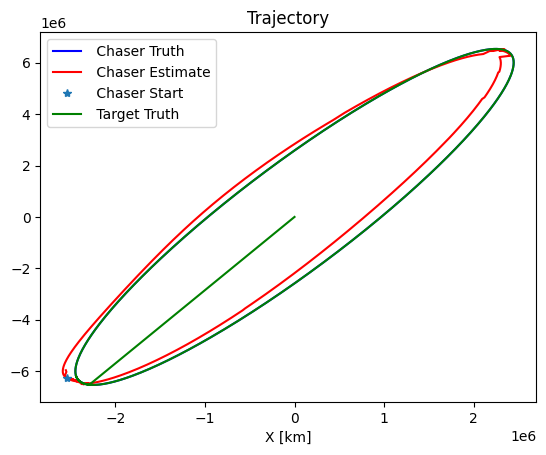

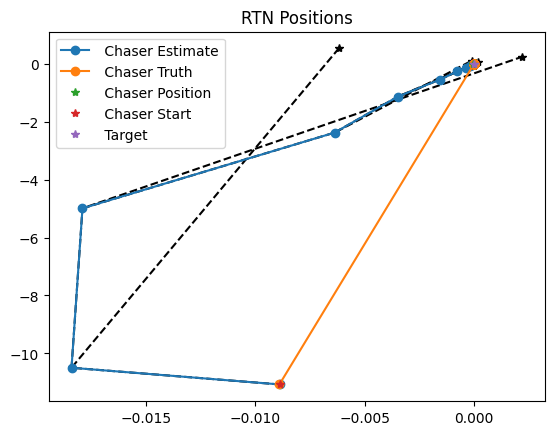

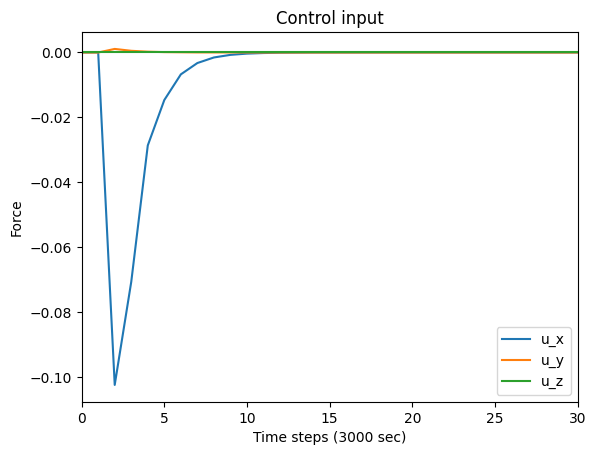

In [5]:
##############################################################################
##############################################################################
###                                                                        ###
###                               PLOTTING                                 ###
###                                                                        ###
##############################################################################
##############################################################################

plt.close('all')


# Convert km to m
x_history  = x_history * 1000
xtrue_history = xtrue_history * 1000
target_true_history = target_true_history * 1000
P_history = P_history * 1000**2

# Trajectory
plt.figure()
plt.title('Trajectory')
q = 10
plt.plot( xtrue_history[0, q:], xtrue_history[1, q:], 'b', label=' Chaser Truth')
plt.plot( x_history[0, q:], x_history[1, q:], 'r', label=' Chaser Estimate')
plt.plot(x_history[0, q], x_history[1, q], '*', label=' Chaser Start')
plt.xlabel('X [km]')

plt.plot(target_true_history[0,:], target_true_history[1,:], 'g', label=' Target Truth')
plt.legend()

plt.figure()
plt.title('RTN Positions')
for t in range (29):
    plt.plot(x_MPC_history[0, 0:4, t], x_MPC_history[1, 0:4, t], '--*', color='k')
plt.plot(x_RTN_history[0,:], x_RTN_history[1,:], '-o', label=' Chaser Estimate')
plt.plot(x_RTN_truth[0,:], x_RTN_truth[1,:], '-o', label=' Chaser Truth')
plt.plot(x_RTN_history[0, q], x_RTN_history[1, q], '*', label=' Chaser Position')
plt.plot(x_RTN_history[0, 0], x_RTN_history[1, 0], '*', label=' Chaser Start')
plt.plot(0, 0, '*', label=' Target')
# print(x_MPC_history.shape)


plt.legend()

plt.figure()
plt.title('Control input')
plt.plot(u_history[0,:], label='u_x')
plt.plot(u_history[1,:], label='u_y')
plt.plot(u_history[2,:], label='u_z')
plt.xlim(0, 30)
plt.ylabel('Force')
plt.xlabel('Time steps (3000 sec)')
plt.legend()

print(u_mpc)

#show plot
plt.show()


In [6]:

# Position ECI

# timeAxis = np.linspace( 0, duration, samples)
# stdev = np.sqrt(P_history)

# fig123, (ax1, ax2, ax3) = plt.subplots(3)
# ax1.set_title('Position ECI')
# ax1.plot( timeAxis, xt_history[0,:] - x_history[0,:])
# ax1.fill_between( timeAxis, stdev[0,:], -stdev[0,:], alpha=0.2 )
# ax1.set_ylim(-20*1000*R, 20*1000*R)
# ax1.grid()
# ax2.plot( timeAxis, xt_history[1,:] - x_history[1,:])
# ax2.fill_between( timeAxis, stdev[1,:], -stdev[1,:], alpha=0.2 )
# ax2.set_ylim(-20*1000*R, 20*1000*R)
# ax2.grid()
# ax3.plot( timeAxis, xt_history[2,:] - x_history[2,:])
# ax3.fill_between( timeAxis, stdev[2,:], -stdev[2,:], alpha=0.2 )
# ax3.set_ylim(-20*1000*R, 20*1000*R)
# ax3.set_xlabel('Time [seconds]')
# ax3.grid()

# # Velocity ECI

# fig456, (ax4, ax5, ax6) = plt.subplots(3)
# ax4.set_title('Velocity ECI')
# ax4.plot( timeAxis, xt_history[3,:] - x_history[3,:])
# ax4.fill_between( timeAxis, stdev[3,:], -stdev[3,:], alpha=0.2 )
# ax4.set_ylim(-20*1000*Rdot, 20*1000*Rdot)
# ax4.grid()
# ax5.plot( timeAxis, xt_history[4,:] - x_history[4,:])
# ax5.fill_between( timeAxis, stdev[4,:], -stdev[4,:], alpha=0.2 )
# ax5.set_ylim(-20*1000*Rdot, 20*1000*Rdot)
# ax5.grid()
# ax6.plot( timeAxis, xt_history[5,:] - x_history[5,:])
# ax6.fill_between( timeAxis, stdev[5,:], -stdev[5,:], alpha=0.2 )
# ax6.set_ylim(-20*1000*Rdot, 20*1000*Rdot)
# ax6.set_xlabel('Time [seconds]')
# ax6.grid()

